## Overview of functionalities

This notebook gives an overview of the functionalities of the dhydamo module.

For install instructions see: https://github.com/openearth/dhydamo#installation

Note that the old version of the package (delft3dfmpy) will not be updated anymore and won't be available through GitHub. New features (RR-modelling, additional hydraulic structures, etc.), will be implemented in dhydamo.

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

## Release notes

The following aspects are new compared to the previous version:
 - culvert length is derived from HyDAMO setting in the GML file instead of the line geometry;
 - spelling of parametrised is now consistent, i.e., "dflowfmmodel.paratemeterised" would now give an error;
 - pumps now expect their margins in m+NAP instead of cm. I.e., the margins are now used directly to set the start/stoplevelsuctionside. Previously they were related to the 'streefwaarde';
 - Boundary conditions can be added to the model as 'dfmmodel.external_forcings.io.from_hydamo(hydamo.boundary_conditions)' instead of running 'add_boundary_condition' in a loop. This does not work (yet) for time series, only for constant boundary conditions
 - structures bridge, universal weir, compound structure and orifice are added.
 - the module was breaking down when pandas was updated to version 1.0.1. Workarounds were immplemented to avoid this.
 - funcdtionality has been implemented to generate also the RR-components of a coupled RR-FM D-HYDRO model.

In [1]:
# Basis
import os
import sys
import shutil
import numpy as np

# Importing relevant classes from delft3dfmpy
from dhydamo import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from dhydamo.datamodels.common import ExtendedGeoDataFrame
from dhydamo import *

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

# allow reloading of module
import importlib


### Read HYDAMO

Note: the data are also added in zipped format, to be unzipped in case of errors with the downloaded gml-files.

In the code section below the different parts or the HyDAMO gml are added. For more info on how to import the different elements from the HyDAMO gml, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing the HyDAMO files are:
- Read the objects from the GML file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number of features with a specfic name. If the name in the gml does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length o f10 characters, so probably a lot of column_mapping is necessary.

In [2]:
# pad to the package containing the dummy-data
pad = 'C:/users/hurkmans/appdata/local/continuum/anaconda3/lib/site-packages/dhydamo/data/'

In [3]:
# initialize the class
hydamo = HyDAMO(extent_file=pad+'gis/selectie_pilot.shp')

# Branches
hydamo.branches.read_gml(pad+'gml/hydroobject.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4

# read from GML
hydamo.crosssections.read_gml(pad+'gml/dwarsprofiel.gml' , 
                              column_mapping={'ruwheidswaardelaag':'ruwheidswaarde'} ,
                              index_col='profielcode' ,
                              groupby_column='profielcode' , 
                              order_column='codevolgnummer')

hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections = hydamo.crosssections.drop(ExtendedGeoDataFrame(geotype=LineString),'code', index_col='profielcode',axis=1)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)

hydamo.parametrised_profiles.read_gml(pad+'gml/NormGeparametriseerdProfiel.gml', column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'})
hydamo.parametrised_profiles.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.parametrised_profiles.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Bridges
hydamo.bridges.read_gml(pad+'gml/brug.gml')
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Culverts
hydamo.culverts.read_gml(
   pad+'gml/duikersifonhevel.gml',
   index_col='code',
   column_mapping={'vormkoker': 'vormcode'},
   clip=hydamo.clipgeo
)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts = hydamo.culverts.drop(ExtendedGeoDataFrame(geotype=LineString),duikers_rekentijd, index_col='code', axis=0)
hydamo.culverts = hydamo.culverts.drop(ExtendedGeoDataFrame(geotype=LineString),duikers_gemalen, index_col='code', axis=0)

# Weirs (including universal weirs)
hydamo.weirs.read_gml(pad+'gml/stuw.gml')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Orifices
hydamo.orifices.read_gml(pad+'gml/onderspuier.gml')
hydamo.orifices.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.orifices.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Closing devices / terugslagkleppen e.d.
hydamo.afsluitmiddel.read_gml(pad+'gml/afsluitmiddel.gml', index_col='code')

# Laterals (imported from shapefile)
hydamo.laterals.read_shp(pad+'sobekdata/Sbk_S3BR_n.shp', 
                         column_mapping={'ID        ': 'code', 
                                         'NAME      ': 'name',
                                         'X         ':'X',
                                         'Y         ':'Y'})
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=  5)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Pumps
hydamo.gemalen.read_gml(pad+'gml/gemaal.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml(pad+'gml/pomp.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml(pad+'gml/sturing.gml', index_col='code')



Plot the model with branches, cross sections and structures. Note that compound structures are not plotted here as they do not have a geometry on their own; they are composed from their sub-structures that do have a geometry and are plotted here.

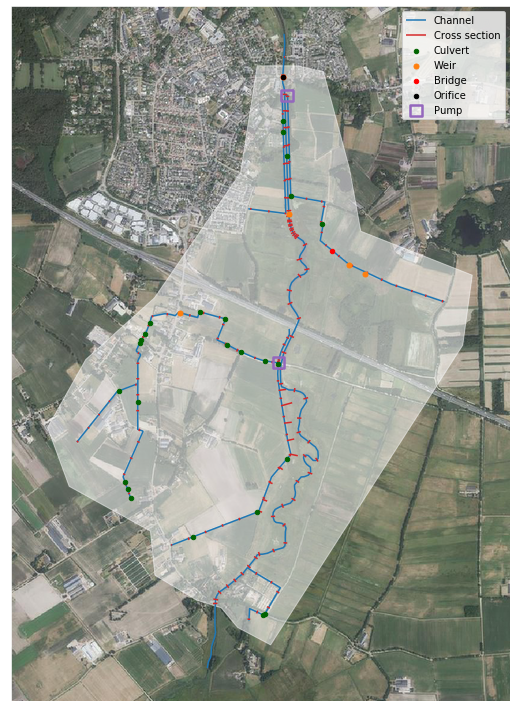

In [4]:
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread(pad+'gis/achtergrond.png')
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel')
hydamo.crosssections.plot(ax=ax, color='C3', label='Cross section')
hydamo.culverts.centroid.plot(ax=ax, color='darkgreen', label='Culvert', markersize=20, zorder=10)
hydamo.weirs.centroid.plot(ax=ax, color='C1', label='Weir', markersize=25, zorder=10)
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10)
hydamo.orifices.plot(ax=ax,color='black',label='Orifice',markersize=20,zorder=10)
hydamo.pumps.plot(
    ax=ax, color='C4', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)

ax.legend()

fig.tight_layout()

### Generate the D-HYDRO FM schematisation

#### Create the 1D network

Convert the geometries to D-HYDRO schematisation:

Start with importing the structures (from HyDAMO in this case), since the position of the structure can be used in defining the position of the 1d nodes. 

Structures can also be added without the HyDAMO imports. One weir is added manually, but this can be done for all implemented structures.

Note that for importing most structures multiple gml-files are needed. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found (either a YZ or a parametrised profile) the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section should contain a 'codegeralateerdobject' containing the ID of the universal weir.
 - culverts can also use an 'afsluitmiddel'; if one is coupled for a specific culvert and its type is 5 (terugslagklep) the flow direction is set 'positive' instead of 'both'.
 - bridges need an associated crosssection (through the field 'codegerelateerdobject' in the cross-section); this can be either 'YZ' or 'parametrised'. The profiles are then processed so a suitable cross-section for a bridge is created;
 - pumps are composed from 'gemalen', 'pompen' and 'sturing'.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects (gemalen, pompen en sturing);
- bridges really need a profile (either 'crosssections' or 'parametrised_profiles' needs to contain a field 'codegerelateerdobject' that points to each bridge).

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

Note that orifices do not yet have an appropriate/definitive definition in HYDAMO. To be able to use it, we now use a separate GML-definition ('onderspuier") but possibly this will be integrated in the definition for weirs. To be continued.


In [5]:
dfmmodel = DFlowFMModel()

# Collect structures
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, hydamo.afsluitmiddel)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.orifices_from_hydamo(hydamo.orifices)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)

# Add a weir manually (equivalent functions exist for all structures):
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='riv_RS1_1810',
    chainage=950.0,
    crestlevel=8.00,
    crestwidth=7.5,
    corrcoeff=1.0    
)


Compound structures are composed of other structures and will not be implemented as such in HyDAMO. D-Flow FM simply needs an ID for every compound structure and a list of structures it should be composed of. They should be snapped to the same branch but not necessarily to the exact same location.

To use, provide a list of ID's of compound structures, and along with, for every compound structure, a nested list of sub-structures. If there are many, these can be read from files (for example).

In [6]:
cmpnd_ids  = ['cmpnd_1','cmpnd_2']
cmpnd_list = [['Orifice_Test1','UWeir_Test2'],
              ['UWeir_Test2','RS1-KBR31']]
dfmmodel.structures.io.compound_structures(cmpnd_ids, cmpnd_list)

After this add the branches and generate a grid.

In [7]:
# Create a 1D schematisation
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=40.0, seperate_structures=True)

Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

In [8]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    dwarsprofielen=hydamo.crosssections,
    parametrised=hydamo.parametrised_profiles
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

1 branches are still missing a cross section.
0 structures are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

In [9]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30)
dfmmodel.crosssections.set_default_definition(definition=default, shift=5.0)

#### Add a 2D mesh

To add a mesh, currently 2 options exist:

1) the converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

In [10]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

# Generate mesh within model bounds
mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(10)
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize)

# Determine the altitude from a digital elevation model
# rasterpath = '../gis/AHNdommel_clipped.tif'
# mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
mesh.altitude_constant(15.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to active)

In [11]:
#from dhydamo.core.mesh2d import Mesh2D
#mesh = Mesh2D()
# import the geometry
#mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
#mesh.altitude_from_raster(rasterpath)
# and add to the model
#dfmmodel.network.add_mesh2d(mesh)

#### Add the 1D-2D links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==True).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [12]:
del dfmmodel.network.links1d2d.faces2d[:]
del dfmmodel.network.links1d2d.nodes1d[:]
dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

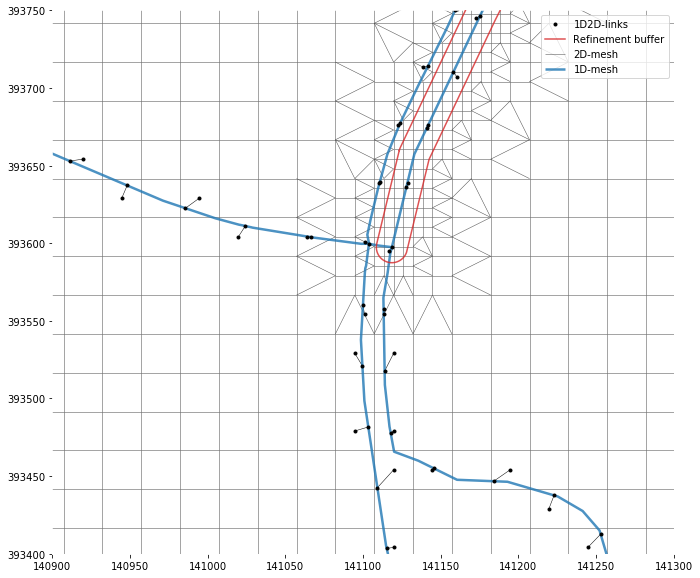

In [13]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

### Boundary conditions for FM

Add boundary conditions to external forcings from a SOBEK time series.

In [14]:
bcs = pd.read_csv(pad+'sobekdata/boundaryconditions.csv', sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)

In [15]:
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_flow_in',
    pt=(140712.056047, 391893.277878),
    bctype='discharge',
    series=bcs['Discharge']
)

dfmmodel.external_forcings.add_boundary_condition(
    name='BC_wlev_down',
    pt=(141133.788766, 395441.748424),
    bctype='waterlevel',
    series=bcs['Waterlevel']
)

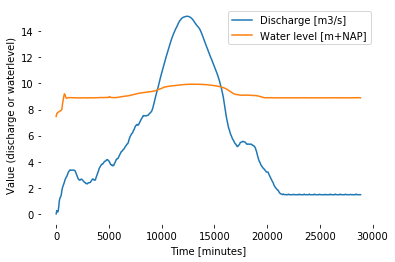

In [16]:
fig, ax = plt.subplots()

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_flow_in']['time'],
    dfmmodel.external_forcings.boundaries['BC_flow_in']['value'],
    label='Discharge [m3/s]'
)

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['time'],
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['value'],
    label='Water level [m+NAP]'
)

ax.set_ylabel('Value (discharge or waterlevel)')
ax.set_xlabel('Time [minutes]')

ax.legend();

In [17]:
# Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

Lateral flow can be obtained from the coupling with the RR-model, or by providing time series. Here, these are read from a Sobek model. In the coupling below, nodes that are not linked to a RR-boundary node are assumed to have a prescribed time series.

If a DFM-model is run offline, timeseries should be provided for all laterals.

In [18]:
###For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy
# # Add the lateral inflows also from the SOBEK results. Naote that the column names in the his-file need to match
# # the id's of the imported lateral locations at the top of this notebook.
rehis = hkvsobekpy.read_his.ReadMetadata(pad+'sobekdata/QLAT.HIS', hia_file='auto')
param = [p for p in rehis.GetParameters() if 'disch' in p][0]
lateral_discharge = rehis.DataFrame().loc[:, param]
lateral_discharge.drop('lat_986', inplace=True, axis=1)

### Generating the RR-model

Catchments are provided as HyDAMO files and are read similarly as the FM files are. They can be GML or shape files. Note that in case of shapefiles column mapping is necessary because the column names are truncated. Required columns include 'code' as the ID and 'lateraleknoopcode' as the associated FM boundary node ID. Furthermore, the attribute 'check_geotype' needs to be set. Default is true; and then the reading will file if the file contains 'MultiPolygon' objects. By disabling the check, these objects will be skipped.

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.

In [19]:
# RR-catchments
hydamo.catchments.read_shp(pad+'gml/afvoergebied_2.shp', index_col='code', 
                           clip=None, check_geotype=False, column_mapping={'lateralekn' : 'lateraleknoopcode', 'administra':'administratiefgebied'})

Features of type "Multipolygon" encountered: they are skipped.


Other input data for RR can be fed by rasters (from which zonal statistics will be extracted) or spatially uniform default values. Three rasters are required: land use, soil type and surface elevation. For each land use type, the area within each catchment is calculated. Surface level is calculated as the median within the catchment, and the most-occurring soil type is used. In all rasters, a NODATA-value of -999 should be used.

#### Boundary nodes

Boundary nodes are assumed to be also included in the FM-model. For every catchment, the boundary identified by 'lateraleknoopocode' in the catchment definitition, is assumed to exist in the laterals. The coordinates are included in the topology of the model as follows:

An RR-model must first be initialized:

In [20]:
drrmodel = DFlowRRModel()

And the necessary (i.e. the one with a catchment associated to them) lateral nodes are also load into the RR model.

In [21]:
drrmodel.external_forcings.io.boundary_from_input(hydamo.laterals, hydamo.catchments)

Eventually, water levels can be read from 1D grid points. For now, an observation point is needed for RR to read water levels from. We add an obseration point for each boundary with a catchment, with an offset of 1 m horizontally and vertically. The new point is then snapped to the branche.

In [22]:
names = []
points = []
from shapely.geometry import Point
for i in drrmodel.external_forcings.boundary_nodes.items():
    names.append('obs_'+i[1]['id'])
    points.append(Point((float(i[1]['px'])+1.,float(i[1]['py'])+1.)))
dfmmodel.observation_points.add_points(points, names, snap_to_1d=True)

dfmmodeling RR and FM must be online. RR reades waterlevels from FM observation points and FM gets discharges from lateral nodes of discharge type 'realtime'.

In [23]:
dfmmodel.external_forcings.io.read_laterals(hydamo.laterals, lateral_discharges=lateral_discharge, rr_boundaries=drrmodel.external_forcings.boundary_nodes)

#### Unpaved nodes

The coding for the land use types needs to be as follows:<br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in cm+NAP.

In [24]:
# all data and settings to create the RR-model
lu_file = pad+'rasters/lgn250.tif'
ahn_file = pad+'rasters/ahn_250_cm.tif'
soil_file = pad+'rasters/soiltypes250.tif'

Other parameters can be set by rasters (i.e. spatially distributed) or uniform. If a number is provided, the module will use this number for all catchments, if a string is provided it is interpreted as a raster file name. For unpaved nodes, these parameters are the storage on the surface, the infiltration capacity, and the initial ground water depth (in m below the surface). The parametrisation for Ernst is taken from a list of layer depths, where each depth is assigned the corresponding resistance from the list of layer_resistances. They need to be of equal length.

In [25]:
surface_storage = 10.0
infiltration_capacity = 100.0
initial_gwd = 0.4

layer_depths = [0.0, 1.0, 2.0]
layer_resistances = [30,200,10000]

Fill the unpaved node with the corresponding ernst definition as follows. 

The last argument to 'unpaved_from_input' contains the polygons that correspond to a meteo-station: here these are identical to each catchment so each catchment gets its own station.  If there are many, small, catchments, it might be more appropriate to use, for instance, Thiessen polygons around gauges. For each catchment, the meteo-station is based on the 'meteo-area;-feature in which the centroid of the catchment falls.

In [26]:
meteo_areas = hydamo.catchments

In [27]:
drrmodel.unpaved.io.unpaved_from_input(hydamo.catchments, lu_file, ahn_file, soil_file, surface_storage, infiltration_capacity, initial_gwd, meteo_areas)
drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances)

#### Paved 

Input for the paved nodes are land use -the area of the paved node is the area of class '14' in the provided land use map- and surface elevation. In addition, the following parameters can all be numbers (spatially uniform) or raster filenames:
- storage on the street <br>
- storage in the sewer system <br>
- capacity of the sewerpumps <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [28]:
street_storage = 10.0
sewer_storage = pad+'rasters/sewstor.tif'
pumpcapacity = pad+'rasters/pumpcap.tif'


To convert to a model definition:

In [29]:
drrmodel.paved.io.paved_from_input(hydamo.catchments, lu_file, ahn_file, street_storage, sewer_storage, pumpcapacity, meteo_areas)

#### Greenhouse nodes

Input for the greenhouse nodes are (again) land use -the area of the paved node is the area of class '15' in the provided land use map- and surface elevation. In addition, the following parameter can be a number (spatially uniform) or a raster filename:
- storage on the roof <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [30]:
roof_storage = pad+'rasters/roofstor.tif'

To convert to a model definition:

In [31]:
drrmodel.greenhouse.io.greenhouse_from_input(hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas)

#### Open water

Input for the open water nodes are only land use -the area of the paved node is the area of class '13' in the provided land use map. 

The meteo-station is assigned in the same way as for unpaved nodes.

In [32]:
drrmodel.openwater.io.openwater_from_input(hydamo.catchments, lu_file, meteo_areas)

#### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

All fluxes are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved to a user-defined field that should be available in the table.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.


In [33]:
seepage_folder = pad+'rasters/kwel'
precip_folder = pad+'rasters/precip'
evap_folder = pad+'rasters/evap'

In [34]:
drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder)
drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder, dissolve_field='administratiefgebied')

We need a function to be able to easily plot all nodes and links

In [35]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point
    geoms = []  
    links = []
    for i in dict.items():
        if 'ar' in i[1]:
            if np.sum([int(s) for s in i[1]['ar'].split(' ')])>0:
                geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
                links.append(LineString((Point(float(i[1]['px']),float(i[1]['py'])),
                                        Point(float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['px']),
                                              float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['py'])))))
        else: 
            geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
    return((gpd.GeoDataFrame(geoms,columns=['geometry'])),gpd.GeoDataFrame(links,columns=['geometry']))

Now all the nodes are filled. The topology is defined as follows: every catchment gets a maximum of four nodes (unpaved, paved, open water and greenhouse). If in the land use map, the appropriate land use does not occur in the catchment, no node is defined. The four nodes are plotted on a horizontal (west-east) line around the catchment centroid in the order of: openwater, unpaved, paved, greenhouse. Every node is connected with the lateral node of the catchnment using a RR-link. The files 3B_NOD.TP and 3B_LINK.TP are created describing this.

In [45]:
handles

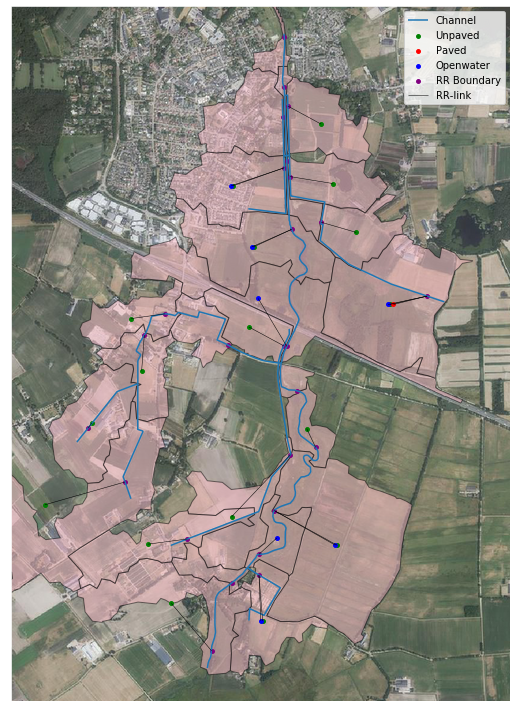

In [50]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread(pad+'gis/achtergrond.png')
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.catchments.plot(ax=ax,label='Catchments', edgecolor='black', facecolor="pink", alpha=0.5)
hydamo.branches.plot(ax=ax, label='Channel')
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(ax=ax,markersize=15,color='green',label='Unpaved')
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax,markersize=15,color='red',label='Paved')
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax,markersize=15,color='yellow',label='Greenhouse')
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax,markersize=15,color='blue',label='Openwater')
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(ax=ax, markersize=15, color='purple',label='RR Boundary')
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color='black',linewidth=0.5,label='RR-link')

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor='pink', edgecolor='black',alpha=0.5)
ax.legend(handles=handles.append(poly),labels=labels.append('Catchments'))
fig.tight_layout()

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. Note that both the GUI and Interaktor do not (yet) support RR, so the only way to carry out a coupled simulation is using DIMR.


In [41]:
# Runtime and output settings
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] = 24.0 * 1 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# for RR model
drrmodel.d3b_parameters['Timestepsize'] = 300
drrmodel.d3b_parameters['StartTime'] = '2000/01/01;00:00:00'
drrmodel.d3b_parameters['EndTime'] = '2000/01/02;00:00:00'
drrmodel.d3b_parameters['RestartIn'] = 0
drrmodel.d3b_parameters['RestartOut'] = 0
drrmodel.d3b_parameters['RestartFileNamePrefix'] ='Test'

drrmodel.dimr_path = r'c:\users\hurkmans\appdata\local\continuum\anaconda3\lib\site-packages\dhydamo\data\x64\dimr\scripts\run_dimr.bat'

# Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir=pad+'testmodel', name='moergestels_broek')
rr_writer = DFlowRRWriter(drrmodel, output_dir=pad+'testmodel', name='moergestels_broek')

# Write as model
# The ldb is just for visualising in the interaktor - there is no RR component there.
fm_writer.objects_to_ldb()
fm_writer.write_all()
rr_writer.write_all()

Finished! Start the coupled model by clicking run.bat in the output model.